# HW 4: Application Questions

CS 539 Machine Learning

Aukkawut Ammartayakun

In [1]:
#import the required libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

## 1. Viterbi Decoding Algorithm (20 points) 

We discussed the Viterbi algorithm to find the most probable
sequence of hidden states for a given observation sequence.

a) For the toy example explained in the attached pdf file (`Example-Viterbi-DNA.pdf`), write the
Viterbi algorithm and repeat the result presented in the pdf file.

In [83]:
# start -> 50% to state H, 50% to state L
# H -> 50% to state H, 50% to state L
# L -> 40% to state H, 60% to state L
# state H distribution of [A,C,G,T] = [0.2,0.3,0.3,0.2]
# state L distribution of [A,C,G,T] = [0.3,0.2,0.2,0.3]

# Define the HMM model
states = ['H', 'L']
start_probs = {'H': 0.5, 'L': 0.5}
trans_probs = {
    'H': {'H': 0.5, 'L': 0.5},
    'L': {'H': 0.4, 'L': 0.6},
}
emis_probs = {
    'H': {'A': 0.2, 'C': 0.3, 'G': 0.3, 'T': 0.2},
    'L': {'A': 0.3, 'C': 0.2, 'G': 0.2, 'T': 0.3},
}

In [93]:
def viterbi(sequence, states, start_probs, trans_probs, emis_probs):
    T = len(sequence)
    num_states = len(states)
    outcome = [[0.0] * num_states for _ in range(T)]
    pointer = [[0] * num_states for _ in range(T)]

    for s, state in enumerate(states):
        outcome[0][s] = start_probs[state] * emis_probs[state][sequence[0]]
        pointer[0][s] = -1
    for t in range(1, T):
        for s, state in enumerate(states):
            max_prob = 0
            max_state = 0
            for prev_s, prev_state in enumerate(states):
                prob = outcome[t-1][prev_s] * trans_probs[prev_state][state] * emis_probs[state][sequence[t]]
                if prob > max_prob:
                    max_prob = prob
                    max_state = prev_s
            outcome[t][s] = max_prob
            pointer[t][s] = max_state
    #print(outcome)
    max_prob = max(outcome[-1])
    best_final_state = outcome[-1].index(max_prob)
    best_path = [states[best_final_state]]
    for t in range(T-1, 0, -1):
        best_state = pointer[t][best_final_state]
        best_path.insert(0, states[best_state])
        best_final_state = best_state
    return best_path

In [92]:
sequence = "GGCACTGAA"
most_probable_path = viterbi(sequence, states, start_probs, trans_probs, emis_probs)
print("Most probable path:", most_probable_path)

Most probable path: ['H', 'H', 'H', 'L', 'L', 'L', 'L', 'L', 'L']


In [85]:
sequence = "GGCA"
most_probable_path = viterbi(sequence, states, start_probs, trans_probs, emis_probs)
print("Most probable path:", most_probable_path)

Most probable path: ['H', 'H', 'H', 'L']


b) Repeat the decoding process in part (a) for the observed sequence of: `AGTCGTA`

In [81]:
sequence = "AGTCGTA"
most_probable_path = viterbi(sequence, states, start_probs, trans_probs, emis_probs)
print("Most probable path:", most_probable_path)

Most probable path: ['L', 'L', 'L', 'H', 'H', 'L', 'L']


## 2.Bayesian Filtering (20 points)

We covered the LDS in the class. A particular interest in LDS is the inference process, where we derive the posterior probability of $x_k$ given the observation till time $k – y_{1\dots k}$. This is called filtering. In https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf, equation set (4.10-4.13), you will find the solution of the filter. This solution can be found in Bishop's textbook, section 13.3, as well.

Here, we build simulation data and derive inference step for a simple LDS model. Let’s assume:

**State Model**
$$p(x_k|x_{k-1})\sim \mathcal{N}(0.99x_{k-1} + 0.1, 0.1)$$

**Observation Model**
$$p(y_k|x_k)\sim \mathcal{N}(-2x_k + 1, 0.4)$$

and $p(x_0)\sim \mathcal{N}(0, 1)$.

a) Create the simulated data from $x_0$ to $x_{100}$ and $y_0$ to $y_{100}$ using the model described above.

In [154]:
# p(x_k | x_{k-1}) = N(x_k | 0.99*x_{k-1}+0.1, 0.1)
# p(x_0) = N(x_0 | 0, 1)

# generate 1000 samples from the above model
x = np.zeros(1000)
x[0] = np.random.normal(0, 1)
for i in range(1, 1000):
    x[i] = np.random.normal(0.99*x[i-1]+0.1, 0.1)

# p(y_k | x_k) = N(y_k | -2*x_k+1, 0.1)
y = np.zeros(1000)
for i in range(1000):
    y[i] = np.random.normal(-2*x[i]+1, 0.1)


b) Follow the equation set (4.10-4.13) to estimate $p(x_k|y_{1\dots k})$ for $k=1,2,\dots,100$. Note that you only observe $y_1$ to $y_{100}$ and you build the posterior probability of $x_k$.

In [192]:
def bayesian_filter(x, prior, transition_prob, observation_prob, observations):
    num_states = len(x)
    # Step 1: Initialize
    posterior = prior
    x_pred = []
    for y_k in observations:
        # Step 2: Prediction step
        predictive = np.zeros(num_states)
        for i, x_k in enumerate(x):
            predictive[i] = np.sum(transition_prob(x, x_k) * posterior)
        #print(predictive)
        predictive /= np.sum(predictive)
        x_pred.append(np.dot(x, predictive))
        # Step 3: Update step
        likelihood = observation_prob(x, y_k)
        posterior = likelihood * predictive / np.sum(likelihood * predictive)
        posterior /= np.sum(posterior)
    return x_pred, posterior
# Define the state and observation models
def state_model(x):
    return 0.99 * x + 0.1

def observation_model(x):
    return -2 * x + 1

# Set the prior distribution
prior = np.ones(1000) / 1000

# Run the Bayesian filter on the data
x_pred, posterior = bayesian_filter(x, prior, lambda x, xp: stats.norm.pdf(x, state_model(xp), np.sqrt(0.1)),
                            lambda x, y: stats.norm.pdf(y, observation_model(x), np.sqrt(0.4)), y)



c) Show the posterior mean and its confidence overlayed on the ground truth $x_k$.

/var/folders/10/9qzh5w8j4l7726t9c8nv50j00000gn/T/ipykernel_40380/2154903588.py:22: RuntimeWarning: invalid value encountered in sqrt
  predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)


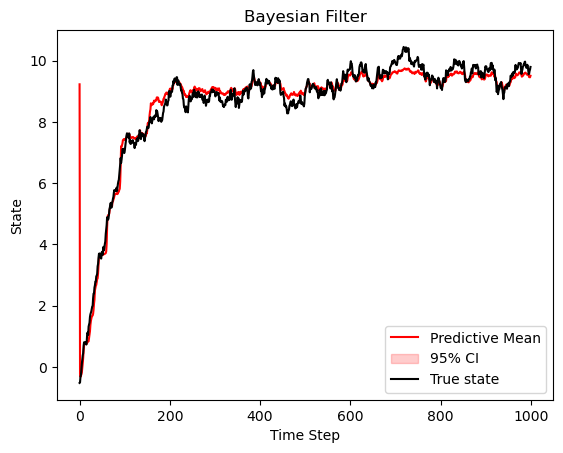

In [193]:
# Compute the mean and confidence interval for each time step
num_observations = len(y)
num_states = len(x)
predictive_mean = np.zeros(num_states)
predictive_lower = np.zeros(num_states)
predictive_upper = np.zeros(num_states)
def transition_prob(x, x_prev, sigma = 0.1):
    mean = 0.99 * x_prev + 0.1
    cov = sigma ** 2
    prob = np.exp(-0.5 * ((x - mean) / cov)**2) / np.sqrt(2 * np.pi * cov)
    prob /= np.sum(prob)
    return prob
def observation_prob(x, y, sigma = 0.4):
    mean = -2 * x + 1
    cov = sigma ** 2
    prob = np.exp(-0.5 * ((y - mean) / cov)**2) / np.sqrt(2 * np.pi * cov)
    return prob

for k in range(num_observations):
    predictive = np.dot(transition_prob(x, x), posterior)
    predictive_mean[k] = x_pred[k]
    predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)
    conf_int = stats.norm.interval(0.95, loc=x_pred[k], scale=predictive_std[k])
    predictive_lower[k] = conf_int[0]
    predictive_upper[k] = conf_int[1]

# Plot the mean and confidence intervals
plt.plot(range(num_observations), x_pred, color='red', label='Predictive Mean')
plt.fill_between(range(num_observations), predictive_lower, predictive_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(num_observations), x, color='black', label='True state')
plt.legend()
plt.title('Bayesian Filter')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

d) Repeat parts b and c for the observation provided in `filter_problem.xlsx` file. The first column is
index, the second is $x_k$, and the last column is $y_k$.

/var/folders/10/9qzh5w8j4l7726t9c8nv50j00000gn/T/ipykernel_40380/3583525000.py:15: RuntimeWarning: invalid value encountered in sqrt
  predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)


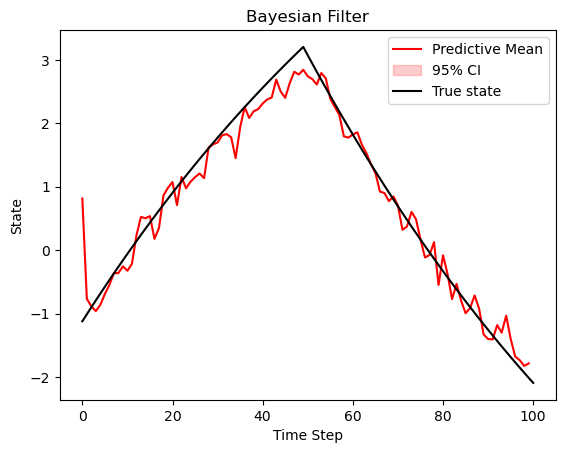

In [198]:
# read the data
data = pd.read_excel('filter_problem.xlsx', index_col=0, header=None)
x = data[1].values
#skip the first row for y
y = data[2].values[1:]
prior = np.ones(len(x)) / len(x)
x_pred, posterior = bayesian_filter(x, prior, lambda x, xp: stats.norm.pdf(x, state_model(xp), np.sqrt(0.1)),
                            lambda x, y: stats.norm.pdf(y, observation_model(x), np.sqrt(0.4)), y)
num_observations = len(y)
num_states = len(x)
predictive_lower = np.zeros(num_states)
predictive_upper = np.zeros(num_states)
for k in range(num_observations):
    predictive = np.dot(transition_prob(x, x), posterior)
    predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)
    conf_int = stats.norm.interval(0.95, loc=x_pred[k], scale=predictive_std[k])
    predictive_lower[k] = conf_int[0]
    predictive_upper[k] = conf_int[1]
plt.plot(range(num_observations), x_pred, color='red', label='Predictive Mean')
plt.fill_between(range(num_observations+1), predictive_lower, predictive_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(num_observations+1), x, color='black', label='True state')
plt.legend()
plt.title('Bayesian Filter')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()


e) Repeat part d using the following state process model.
$$p(x_k|x_{k-1}) \sim \mathcal{N}(x_{k-1}, 0.2)$$
The observation model will be the same.

/var/folders/10/9qzh5w8j4l7726t9c8nv50j00000gn/T/ipykernel_40380/140310664.py:22: RuntimeWarning: invalid value encountered in sqrt
  predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)


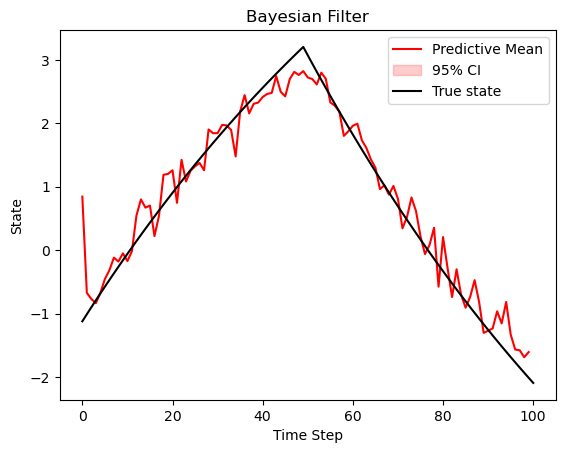

In [199]:
def state_model(x):
    return x
def transition_prob(x, x_prev, sigma = 0.2):
    mean = x_prev
    cov = sigma ** 2
    prob = np.exp(-0.5 * ((x - mean) / cov)**2) / np.sqrt(2 * np.pi * cov)
    prob /= np.sum(prob)
    return prob
data = pd.read_excel('filter_problem.xlsx', index_col=0, header=None)
x = data[1].values
#skip the first row for y
y = data[2].values[1:]
prior = np.ones(len(x)) / len(x)
x_pred, posterior = bayesian_filter(x, prior, lambda x, xp: stats.norm.pdf(x, state_model(xp), np.sqrt(0.2)),
                            lambda x, y: stats.norm.pdf(y, observation_model(x), np.sqrt(0.4)), y)
num_observations = len(y)
num_states = len(x)
predictive_lower = np.zeros(num_states)
predictive_upper = np.zeros(num_states)
for k in range(num_observations):
    predictive = np.dot(transition_prob(x, x), posterior)
    predictive_std = np.sqrt(np.dot(x ** 2, predictive) - x_pred[k] ** 2)
    conf_int = stats.norm.interval(0.95, loc=x_pred[k], scale=predictive_std[k])
    predictive_lower[k] = conf_int[0]
    predictive_upper[k] = conf_int[1]
plt.plot(range(num_observations), x_pred, color='red', label='Predictive Mean')
plt.fill_between(range(num_observations+1), predictive_lower, predictive_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(range(num_observations+1), x, color='black', label='True state')
plt.legend()
plt.title('Bayesian Filter')
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()


f) Discuss your results in c, d, and e parts.

Result from part c) shows the more or less smoother version of the true state. In constrast, the result from part d) and e) are not smooth at all. Instead, changing the transition model surprisingly introduces the noise into the predicted state.

## 3. Sequential MCMC (20 points)

In reading assignment 2, we learn about “particle filtering”. Here, we use the SIS technique to solve the previous filtering problem.

a) Use 100 particles to estimate $p(x_k|y_{1\dots k})$ for `filter_problem.xlsx` file. Show the mean of your estimate and its confidence interval overlayed on the ground truth $x_k$. Use the state model discussed in part e of the previous problem.

In [108]:
# read the data
data = pd.read_excel('filter_problem.xlsx', index_col=0, header=None)
x = data[1].values
#skip the first row for y
y = data[2].values[1:]

In [141]:
def resampling(particles, weights, n_particles):
    '''
    algorithm 2
    '''
    cdf = np.zeros(n_particles)
    cdf[0] = weights[0]
    for i in range(1, n_particles):
        cdf[i] = cdf[i-1] + weights[i]
    resampled_particles = np.zeros(n_particles)
    u_1 = np.random.uniform(0, 1/n_particles)
    i = 0
    for j in range(n_particles):
        u_j = u_1 + j / n_particles
        while u_j > cdf[i]:
            i += 1
        resampled_particles[j] = particles[i]
    return resampled_particles

def q(x_prev):
    return np.random.normal(x_prev, 0.2)

def obs_likelihood(x, y_k):
    return np.exp(-(y_k - (-2 * x + 1))**2 / (2 * 0.4**2)) / (np.sqrt(2 * np.pi) * 0.4)

n_particles = 100
n_timesteps = len(y) 
particles = np.random.normal(0, 1, n_particles)
weights = np.ones(n_particles) / n_particles
x_est = np.zeros(n_timesteps + 1)  
x_est[0] = np.mean(particles)      
for k in range(n_timesteps):
    particles = np.array([q(x_prev) for x_prev in particles])
    weights *= obs_likelihood(particles, y[k])
    weights /= np.sum(weights)
    particles = resampling(particles, weights, n_particles)
    weights = np.ones(n_particles) / n_particles
    x_est[k + 1] = np.mean(particles)

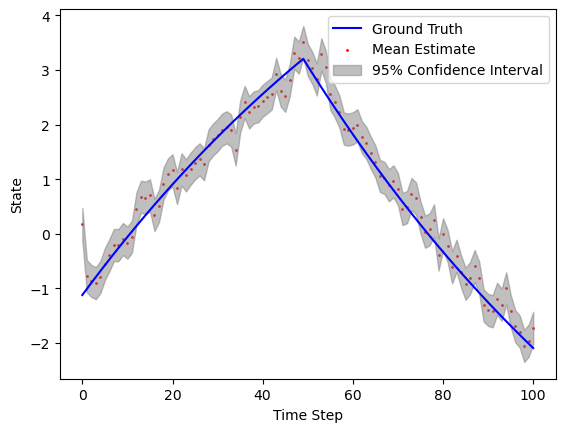

In [144]:
upper_bound = x_est + 1.96 * np.sqrt(np.var(particles))
lower_bound = x_est - 1.96 * np.sqrt(np.var(particles))
plt.plot(x, label='Ground Truth', color='blue')
plt.scatter(range(len(x)),x_est, label='Mean Estimate', color='red', s=1)
plt.fill_between(np.arange(n_timesteps + 1), lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

b) Repeat the same procedure with 1000 particles.

In [127]:
n_particles = 1000
n_timesteps = len(y)
particles = np.random.normal(0, 1, n_particles)
weights = np.ones(n_particles) / n_particles
x_est = np.zeros(n_timesteps + 1)
x_est[0] = np.mean(particles)   
for k in range(n_timesteps):
    particles = np.array([q(x_prev) for x_prev in particles])
    weights *= obs_likelihood(particles, y[k])
    weights /= np.sum(weights)
    particles = resampling(particles, weights, n_particles)
    weights = np.ones(n_particles) / n_particles
    x_est[k + 1] = np.mean(particles)

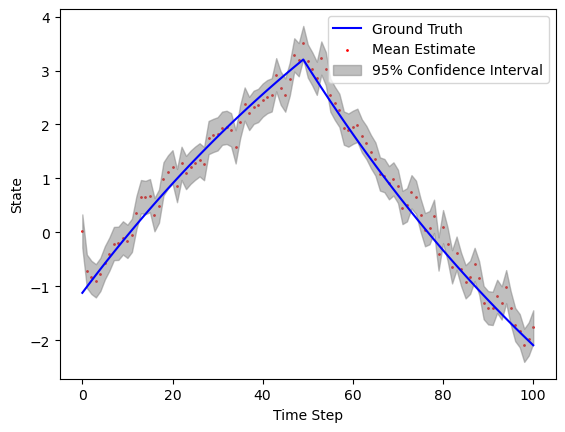

In [137]:
upper_bound = x_est + 1.96 * np.sqrt(np.var(particles))
lower_bound = x_est - 1.96 * np.sqrt(np.var(particles))
plt.plot(x, label='Ground Truth', color='blue')
plt.scatter(range(len(x)),x_est, label='Mean Estimate', color='red', s=1)
plt.fill_between(np.arange(n_timesteps + 1), lower_bound, upper_bound, color='gray', alpha=0.5, label='95% Confidence Interval')
plt.legend()
plt.xlabel('Time Step')
plt.ylabel('State')
plt.show()

## 4. GP and Linear Regression (20 points)

Gaussian Process is a powerful tool for regression and classification problems. Here, we will compare GP and linear regression prediction accuracy in a regression problem with the dataset presented in `synchronous_machine.csv` file.

For this problem, you need to shuffle data and use 10-fold cross-validation.

a) Use GP with “exponentiated quadratic kernel” and show your test and training MSE. For the Kernel parameters, you might examine a set of different values and pick the one that provides the lowest MSE. Note that it is possible to estimate the kernel parameters as well.

In [63]:
#read the data
data = pd.read_csv('synchronous_machine.csv')
def kernel(X1, X2, l=1.0, sigma_f=1.0):
    '''
    rbf kernel
    K(x,x') = sigma_f^2 * exp(-1/2 * ||x-x'||^2 / l^2)
    '''
    sqdist = np.sum(X1 ** 2, 1).reshape(-1, 1) + np.sum(X2 ** 2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f ** 2 * np.exp(-0.5*sqdist/(l ** 2))
def gaussian_process_regression(X_train, Y_train, X_test, l=0.5, sigma_f=0.5, sigma_y=1e-3):
    K = kernel(X_train, X_train, l, sigma_f) + sigma_y ** 2 * np.eye(len(X_train))
    K_s = kernel(X_train, X_test, l, sigma_f)
    K_ss = kernel(X_test, X_test, l, sigma_f) + 1e-8 * np.eye(len(X_test))
    K_inv = np.linalg.pinv(K)
    mu_s = K_s.T.dot(K_inv).dot(Y_train)
    cov_s = K_ss - K_s.T.dot(K_inv).dot(K_s)
    return mu_s, cov_s

In [52]:
#10-fold cross validation
def cross_validation(X, Y):
    #shuffle the data
    idx = np.random.permutation(len(X))
    X = X[idx]
    Y = Y[idx]
    #split the data into 10 folds
    X_folds = np.array_split(X, 10)
    Y_folds = np.array_split(Y, 10)
    #perform 10-fold cross validation
    temse, trmse = [], []
    for i in range(10):
        X_test = X_folds[i]
        Y_test = Y_folds[i]
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        Y_train = np.concatenate(Y_folds[:i] + Y_folds[i+1:])
        mu_s, cov_s = gaussian_process_regression(X_train, Y_train, X_test)
        #compute the test mean squared error
        mse = np.mean((Y_test - mu_s) ** 2)
        temse.append(mse)
        #print(f'MSE fold {i}: {mse}')
        #compute the train mean squared error
        mu_s, cov_s = gaussian_process_regression(X_train, Y_train, X_train)
        mse = np.mean((Y_train - mu_s) ** 2)
        trmse.append(mse)
        #print(f'MSE train {i}: {mse}')
    print(f'Mean test MSE: {np.mean(temse)}')
    print(f'sd test MSE: {np.std(temse)}')
    print(f'Mean train MSE: {np.mean(trmse)}')
    print(f'sd train MSE: {np.std(trmse)}')

In [53]:
# train the model, let assume that the last variables are the target and the rest are the features
X = data.values[:, :-1]
Y = data.values[:, -1]
cross_validation(X, Y)

Mean test MSE: 4.330503956511053e-08
sd test MSE: 4.597447324776555e-08
Mean train MSE: 9.508474286045133e-09
sd train MSE: 1.2238168505167442e-10


b) Use linear regression using 4 predictors and show your test and training MSE.

In [56]:
def linear_regression(X, Y):
    #add bias
    X = np.hstack((np.ones((X.shape[0], 1)), X))
    #compute the weights
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    #compute the mean squared error
    return W

def cross_validation_lr(X,Y):
    #shuffle the data
    idx = np.random.permutation(len(X))
    X = X[idx]
    Y = Y[idx]
    #split the data into 10 folds
    X_folds = np.array_split(X, 10)
    Y_folds = np.array_split(Y, 10)
    #perform 10-fold cross validation
    temse, trmse = [], []
    for i in range(10):
        X_test = X_folds[i]
        Y_test = Y_folds[i]
        X_train = np.concatenate(X_folds[:i] + X_folds[i+1:])
        Y_train = np.concatenate(Y_folds[:i] + Y_folds[i+1:])
        W = linear_regression(X_train, Y_train)
        #compute the test mean squared error
        #add bias
        X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))
        mse = np.mean((Y_test - X_test.dot(W)) ** 2)
        temse.append(mse)
        #print(f'MSE fold {i}: {mse}')
        #compute the train mean squared error
        #add bias
        X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
        mse = np.mean((Y_train - X_train.dot(W)) ** 2)
        trmse.append(mse)
        #print(f'MSE train {i}: {mse}')
    print(f'Mean test MSE: {np.mean(temse)}')
    print(f'sd test MSE: {np.std(temse)}')
    print(f'Mean train MSE: {np.mean(trmse)}')
    print(f'sd train MSE: {np.std(trmse)}')
cross_validation_lr(X, Y)

Mean test MSE: 1.7902618283954419e-28
sd test MSE: 1.2802487717005308e-28
Mean train MSE: 1.7333158268170442e-28
sd train MSE: 1.1438543797390682e-28


c) Discuss the result in parts a and b.

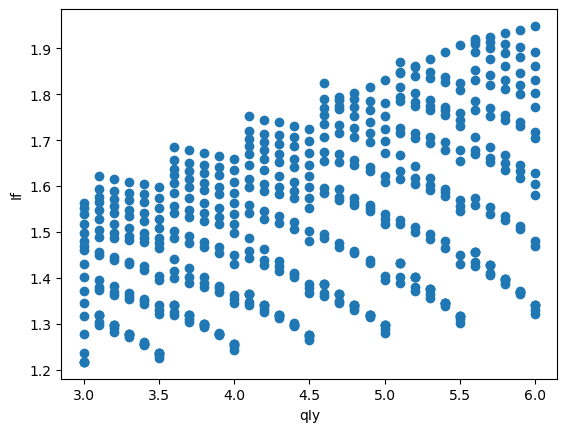

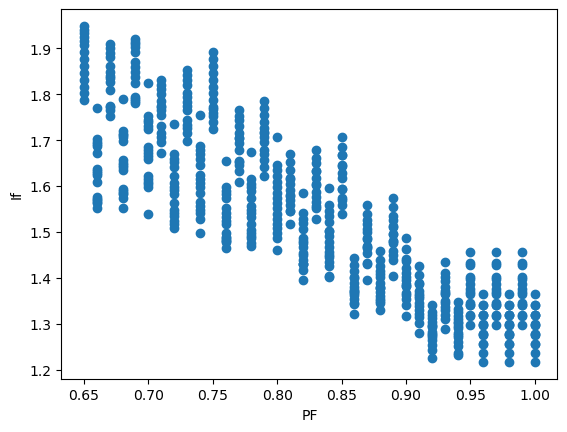

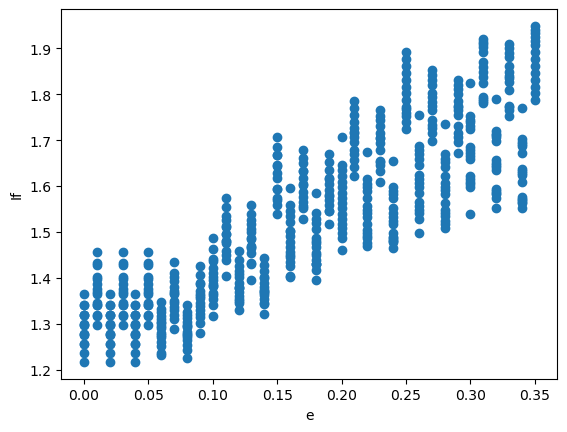

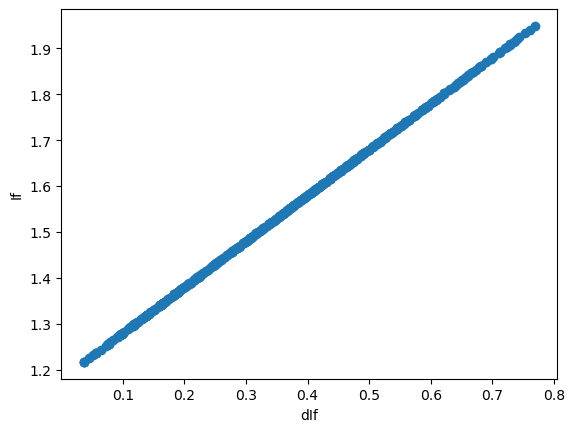

In [57]:
#scatter plot of each feature vs the target
for i in range(X.shape[1]):
    plt.scatter(X[:, i], Y)
    plt.xlabel(data.columns[i])
    plt.ylabel(data.columns[-1])
    plt.show()

As shown in the pairplot that there is one feature that is highly correlated with the target variable. In linear regression, this would make the model closed to be $y = \beta_0 + \beta_1 x_1$ given the highly correlated feature $x_1$ which ignore the other features. In GP, the kernel function will take into account all the features and the model will be more flexible.